In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [32]:
# Load the CSV file
df = pd.read_csv("fitness_keypoints_full.csv")

# Drop any rows with NaN values (if present)
df.dropna(inplace=True)

# Extract features (pose keypoints) and labels
X = df.iloc[:, :-1].values  # All columns except the last one (features)
y = df.iloc[:, -1].values   # Last column (exercise label)

# Encode exercise labels into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training & testing (70-10-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# Convert to PyTorch tensors
X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))
y_train, y_val, y_test = map(torch.tensor, (y_train, y_val, y_test))

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: torch.Size([11132, 100]), Validation set: torch.Size([1574, 100]), Test set: torch.Size([3198, 100])


In [33]:
import numpy as np
import collections

class_counts = collections.Counter(y_train.numpy())
print("Class distribution in training set:", class_counts)


Class distribution in training set: Counter({np.int64(14): 1377, np.int64(12): 1221, np.int64(7): 944, np.int64(0): 928, np.int64(13): 914, np.int64(8): 819, np.int64(9): 756, np.int64(1): 716, np.int64(2): 707, np.int64(3): 671, np.int64(6): 548, np.int64(11): 459, np.int64(10): 436, np.int64(5): 352, np.int64(15): 144, np.int64(4): 140})


In [34]:
class PoseBERT(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PoseBERT, self).__init__()
        config = BertConfig(
            hidden_size=input_dim,  # Match to input feature size (100)
            num_hidden_layers=4,
            num_attention_heads=4,
            intermediate_size=512
        )
        self.bert = BertModel(config)
        self.fc = nn.Linear(input_dim, num_classes)  # Change from 256 → input_dim

    def forward(self, x):
        outputs = self.bert(inputs_embeds=x)
        x = outputs.last_hidden_state[:, 0, :]  # Extract first token embedding
        x = self.fc(x)  # Ensure input size matches FC layer
        return x


# Initialize model
num_classes = len(label_encoder.classes_)
model = PoseBERT(input_dim=X_train.shape[1], num_classes=num_classes).to("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [35]:
# Ensure target labels are long integers
y_train, y_val, y_test = map(lambda y: y.long(), (y_train, y_val, y_test))

num_epochs = 10
batch_size = 32  # Use batch training

# Compute class weights properly
class_counts = torch.tensor([1377, 1221, 944, 928, 914, 819, 756, 716, 707, 671, 548, 459, 436, 352, 144, 140], dtype=torch.float)
class_weights = class_counts.max() / class_counts  # Scale relative to most frequent class

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = class_weights.to(device)

# Define weighted loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Use DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for i in tqdm(range(len(X_train))):
        inputs = X_train[i].float().unsqueeze(0).unsqueeze(0).to(device)  
        labels = y_train[i].unsqueeze(0).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(X_train):.4f}")

print("Training Complete!")


100%|██████████| 11132/11132 [04:46<00:00, 38.80it/s]


Epoch 1/10, Loss: 2.5925


100%|██████████| 11132/11132 [05:42<00:00, 32.46it/s] 


Epoch 2/10, Loss: 2.3167


100%|██████████| 11132/11132 [07:21<00:00, 25.24it/s] 


Epoch 3/10, Loss: 1.9918


100%|██████████| 11132/11132 [10:18<00:00, 18.00it/s]


Epoch 4/10, Loss: 1.8480


100%|██████████| 11132/11132 [08:09<00:00, 22.75it/s]


Epoch 5/10, Loss: 1.7791


100%|██████████| 11132/11132 [08:22<00:00, 22.17it/s] 


Epoch 6/10, Loss: 1.7211


100%|██████████| 11132/11132 [05:17<00:00, 35.03it/s]


Epoch 7/10, Loss: 1.6661


100%|██████████| 11132/11132 [05:03<00:00, 36.67it/s]


Epoch 8/10, Loss: 1.6176


100%|██████████| 11132/11132 [05:06<00:00, 36.33it/s]


Epoch 9/10, Loss: 1.5737


100%|██████████| 11132/11132 [04:59<00:00, 37.19it/s]


Epoch 10/10, Loss: 1.5244
Training Complete!


In [36]:
import torch

# Define save path
model_save_path = "posebert_model.pth"

# Save model state dict
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': num_classes,  # Save num_classes for later use
}, model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to posebert_model.pth


100%|██████████| 3198/3198 [00:14<00:00, 227.62it/s]
c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

Classification Report:
                      precision    recall  f1-score   support

barbell biceps curl       0.50      0.60      0.55       267
        bench press       0.66      0.56      0.61       208
  chest fly machine       0.49      0.56      0.52       189
           deadlift       0.62      0.56      0.59       218
decline bench press       0.87      0.34      0.49        38
        hammer curl       0.00      0.00      0.00       101
         hip thrust       0.53      0.61      0.57       180
incline bench press       0.41      0.41      0.41       254
       lat pulldown       0.45      0.74      0.56       228
      lateral raise       0.57      0.50      0.53       222
      leg extension       0.68      0.51      0.59       142
         leg raises       0.65      0.42      0.51       110
              plank       0.63      0.95      0.76       365
            pull Up       0.54      0.22      0.31       264
            push-up       0.75      0.83      0.78       374

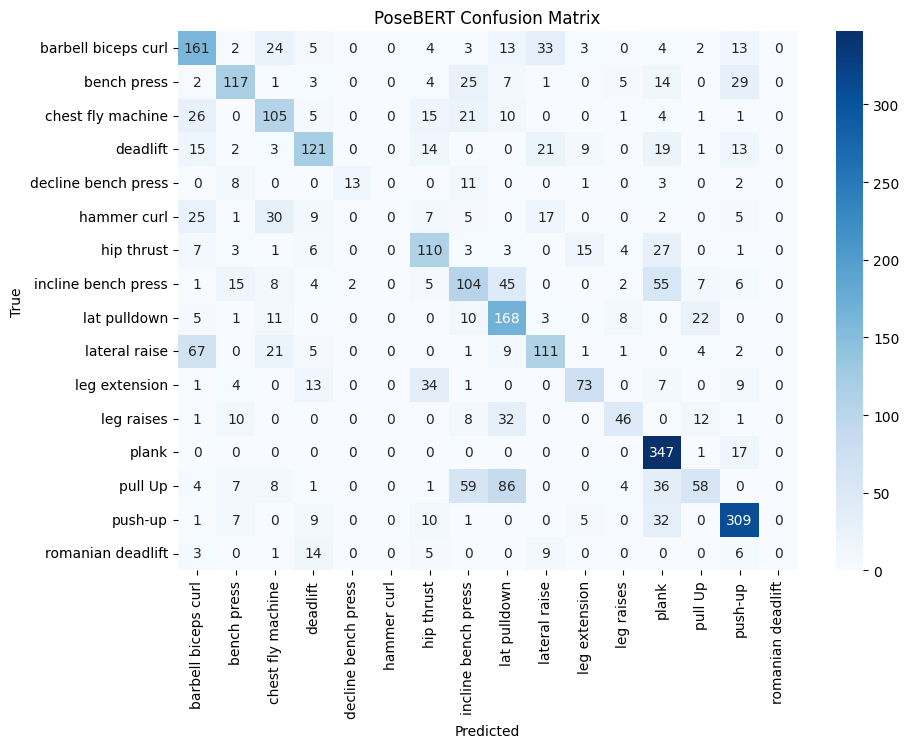

In [37]:
# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        # Ensure the input shape has three dimensions
        inputs = X_test[i].float().unsqueeze(0).unsqueeze(1).to(device)  # Adding a second unsqueeze for sequence dimension
        labels = y_test[i].unsqueeze(0).to(device)


        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_pred.append(predicted.cpu().numpy()[0])
        y_true.append(labels.cpu().numpy()[0])

# Compute F1-score & Classification Report
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Compute & Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PoseBERT Confusion Matrix")
plt.show()

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [54]:
# Load preprocessed pose keypoints data
df = pd.read_csv("fitness_keypoints_full.csv")

# Extract keypoints (features) and labels
X = df.iloc[:, :-1].values  # Pose keypoints
y = df.iloc[:, -1].values   # Exercise labels

# Encode labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float)
y_encoded = torch.tensor(y_encoded, dtype=torch.long)

# Define body edges (connections between joints)
edges = torch.tensor([
    [0, 1], [1, 2], [2, 3],  # Left arm
    [0, 4], [4, 5], [5, 6],  # Right arm
    [0, 7], [7, 8], [8, 9],  # Spine
    [8, 10], [10, 11], [11, 12],  # Left leg
    [8, 13], [13, 14], [14, 15]   # Right leg
], dtype=torch.long).T  # PyTorch Geometric expects (2, num_edges)


In [55]:
# Create graph dataset
graph_data = []
for i in range(len(X)):
    data = Data(x=X[i].view(-1, 1), edge_index=edges, y=y_encoded[i])
    graph_data.append(data)

# Split into train and test sets
train_size = int(0.7 * len(graph_data))
val_size = int(0.1 * len(graph_data))
test_size = len(graph_data) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(graph_data, [train_size, val_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [56]:
class PoseGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(PoseGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Aggregate node features
        x = self.fc(x)
        return x

# Initialize model
num_classes = len(label_encoder.classes_)
model = PoseGNN(input_dim=1, hidden_dim=64, num_classes=num_classes).to("cpu")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training Complete!")

Epoch [1/100], Loss: 2.4238
Epoch [2/100], Loss: 2.3148
Epoch [3/100], Loss: 2.2853
Epoch [4/100], Loss: 2.2688
Epoch [5/100], Loss: 2.2518
Epoch [6/100], Loss: 2.2349
Epoch [7/100], Loss: 2.2098
Epoch [8/100], Loss: 2.1806
Epoch [9/100], Loss: 2.1523
Epoch [10/100], Loss: 2.1281
Epoch [11/100], Loss: 2.1098
Epoch [12/100], Loss: 2.0932
Epoch [13/100], Loss: 2.0795
Epoch [14/100], Loss: 2.0671
Epoch [15/100], Loss: 2.0569
Epoch [16/100], Loss: 2.0475
Epoch [17/100], Loss: 2.0382
Epoch [18/100], Loss: 2.0278
Epoch [19/100], Loss: 2.0185
Epoch [20/100], Loss: 2.0097
Epoch [21/100], Loss: 1.9997
Epoch [22/100], Loss: 1.9924
Epoch [23/100], Loss: 1.9844
Epoch [24/100], Loss: 1.9779
Epoch [25/100], Loss: 1.9706
Epoch [26/100], Loss: 1.9618
Epoch [27/100], Loss: 1.9552
Epoch [28/100], Loss: 1.9486
Epoch [29/100], Loss: 1.9411
Epoch [30/100], Loss: 1.9354
Epoch [31/100], Loss: 1.9264
Epoch [32/100], Loss: 1.9212
Epoch [33/100], Loss: 1.9157
Epoch [34/100], Loss: 1.9080
Epoch [35/100], Loss: 1

c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Manann\anaconda3\envs\fitness-ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Classification Report:
                      precision    recall  f1-score   support

barbell biceps curl       0.22      0.27      0.24       279
        bench press       0.26      0.04      0.08       204
  chest fly machine       0.33      0.17      0.23       205
           deadlift       0.16      0.03      0.06       173
decline bench press       0.00      0.00      0.00        37
        hammer curl       0.00      0.00      0.00        94
         hip thrust       0.00      0.00      0.00       171
incline bench press       0.33      0.39      0.36       282
       lat pulldown       0.16      0.47      0.24       243
      lateral raise       0.00      0.00      0.00       202
      leg extension       0.00      0.00      0.00       129
         leg raises       0.58      0.20      0.30       122
              plank       0.91      0.75      0.82       342
            pull Up       0.27      0.38      0.32       285
            push-up       0.28      0.68      0.40       375

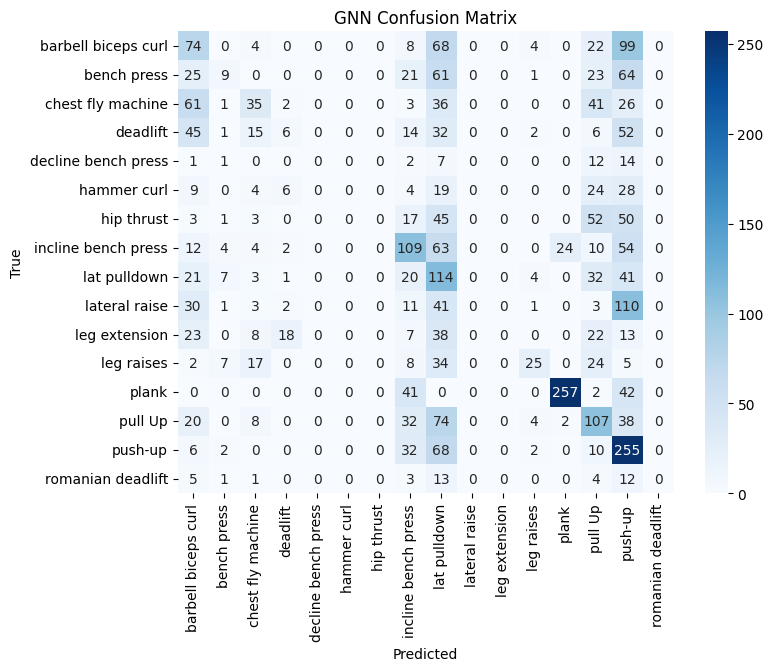

In [43]:
# Evaluate Model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for data in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GNN Confusion Matrix")
plt.show()

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Set Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ResNet18
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
resnet.eval().to(device)

# Define Transformation for ResNet Input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [18]:
mp_pose = mp.solutions.pose.Pose()

def extract_video_frames(video_path, sequence_length=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = mp_pose.process(frame_rgb)

        if results.pose_landmarks:
            keypoints = []
            for lm in results.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])

            # Fix: Ensure Exactly 100 Features
            while len(keypoints) < 100:  
                keypoints.append(0.0)  # Pad missing features
            keypoints = keypoints[:100]  # Trim extra values
            
            frames.append(keypoints)

        if len(frames) >= sequence_length:
            break

    cap.release()

    # Fix: Skip Videos Without Keypoints
    if len(frames) == 0:
        print(f"⚠️ Skipping video: {video_path} (No keypoints detected)")
        return None  # Return None to indicate skipping

    # Handle Short Sequences
    while len(frames) < sequence_length:
        frames.append(frames[-1])
    
    return torch.tensor(frames[:sequence_length], dtype=torch.float).to(device)


In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, num_classes=16):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Initialize Model
num_classes = 16
model = LSTMModel(input_dim=100, hidden_dim=128, num_classes=num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import os

# Define the directory where videos are stored
video_dir = "workoutfitness-video"

# Create a dictionary mapping video file names to labels
labels = {}
label_map = {}  # Stores class name → numeric label mapping

# Assign a unique index to each exercise category
for idx, exercise in enumerate(sorted(os.listdir(video_dir))):  # Sorted for consistency
    exercise_path = os.path.join(video_dir, exercise)
    
    if os.path.isdir(exercise_path):  # Ensure it's a folder
        label_map[exercise] = idx  # Assign label

        # Map each video inside the folder to its respective class index
        for file in os.listdir(exercise_path):
            if file.endswith(('.mp4', '.mov', '.avi')):  # Ensure it's a video file
                labels[file] = idx

# Print the label mapping
print("Class Label Mapping:", label_map)
print("Total videos labeled:", len(labels))

# Check if labels are correctly formatted before using them in dataset
if not isinstance(labels, dict):
    raise TypeError(f"Expected labels to be a dictionary, but got {type(labels)}")



Class Label Mapping: {'barbell biceps curl': 0, 'bench press': 1, 'chest fly machine': 2, 'deadlift': 3, 'decline bench press': 4, 'hammer curl': 5, 'hip thrust': 6, 'incline bench press': 7, 'lat pulldown': 8, 'lateral raise': 9, 'leg extension': 10, 'leg raises': 11, 'plank': 12, 'pull Up': 13, 'push-up': 14, 'romanian deadlift': 15}
Total videos labeled: 459


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_dir, labels, sequence_length=30):
        self.video_dir = video_dir
        
        # Ensure labels is a dictionary
        if not isinstance(labels, dict):
            raise TypeError(f"Expected labels to be a dictionary, but got {type(labels)}")
        
        self.labels = labels
        self.sequence_length = sequence_length
        self.video_files = list(labels.keys())  # This now works

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_files[idx])
        frames = extract_video_frames(video_path, self.sequence_length)
        
        if frames is None:
            return None  # Skip this sample
        
        label = torch.tensor(self.labels[self.video_files[idx]], dtype=torch.long)

        # Extract ResNet features
        with torch.no_grad():
            features = resnet(frames).squeeze(-1).squeeze(-1)  # Shape: (sequence_length, 512)
        
        return features, label


# Load Dataset and DataLoader
video_dir = "workoutfitness-video"
train_dataset = VideoDataset(video_dir, labels)
train_loader = DataLoader([sample for sample in train_dataset if sample is not None], batch_size=4, shuffle=True)

print(f"Loaded {len(train_dataset)} videos for training")


⚠️ Skipping video: workoutfitness-video\barbell biceps curl_1.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_10.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_11.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_12.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_13.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_14.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_15.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_16.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_17.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_18.mp4 (No keypoints detected)
⚠️ Skipping video: workoutfitness-video\barbell biceps curl_19.mp4 (No keypoints detected)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [28]:
num_epochs = 10  # Increase epochs if needed

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Ensure train_loader is not empty
    if len(train_loader) == 0:
        raise ValueError("No valid samples found in training dataset! Check data preprocessing.")

    for inputs, labels in tqdm(train_loader):
        if inputs.shape[0] == 0:  # Avoid empty batches
            continue

        # ✅ Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Ensure inputs have correct shape (batch_size, sequence_length, feature_dim)
        if inputs.dim() != 3:
            raise ValueError(f"Expected input shape (batch_size, sequence_length, feature_dim), but got {inputs.shape}")

        optimizer.zero_grad()
        outputs = model(inputs)

        # Ensure outputs match labels
        if outputs.shape[0] != labels.shape[0]:
            raise ValueError(f"Shape mismatch: outputs {outputs.shape}, labels {labels.shape}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training Complete!")


 13%|█▎        | 15/115 [01:06<07:25,  4.45s/it]

⚠️ Skipping video: workoutfitness-video\romanian deadlift\romanian deadlift_3.mov (No keypoints detected)


TypeError: expected Tensor as element 3 in argument 0, but got NoneType

In [ ]:
model_save_path = "resnet_lstm_fitness.pth"
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved to {model_save_path}")


  0%|          | 0/348 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)